### DCGAN to generate face images
Taken from keras.io/generative/dcgan_overriding_train_step/
* Author: fchollet
* Description: A simple DCGAN trained using fit() by overriding train_step on CelebA images.

### Setup

In [7]:
import tensorflow as tf
print(tf.__version__) 
 

2.13.0


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os


In [23]:
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import backend as K

from keras import ops
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

ImportError: cannot import name 'ops' from 'keras' (C:\Users\ibrah101\AppData\Roaming\Python\Python38\site-packages\keras\__init__.py)

### Prepare the Fashion-MNIST data

In [19]:
IMG_SHAPE = (28, 28, 1)

noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


## Create the Discriminator

In [30]:

img_input = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(img_input)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation="sigmoid")(x)

discriminator = keras.Model(img_input, x, name="discriminator")

discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_39 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_40 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 4, 4, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_41 (LeakyReLU)           │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,161 (1.51 MB)

 Trainable params: 396,161 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

### Create the generator

It mirrors the discriminator, replacing Conv2D layers with Conv2DTranspose layers.

In [31]:

latent_dim = 128

generator = keras.Sequential([
    layers.Input(shape=(latent_dim,)),

    layers.Dense(7 * 7 * 128, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Reshape((7, 7, 128)),


    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),


    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(1, kernel_size=3, padding="same", activation="tanh")
], name="generator")

generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 6272)                │         802,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_42 (LeakyReLU)           │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 14, 14, 128)         │         262,144 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_43 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 28, 28, 64)          │         131,072 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_44 (LeakyReLU)           │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,222,465 (4.66 MB)

 Trainable params: 1,209,537 (4.61 MB)

 Non-trainable params: 12,928 (50.50 KB)

### Override train_step

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### Create a callback that periodically saves generated images


In [6]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

### Train the end-to-end model


In [16]:
epochs = 60  # In practice, use ~100 epochs
BATCH_SIZE = 512

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(BATCH_SIZE)
gan.fit(train_dataset, epochs=epochs)


Epoch 1/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - d_loss: 0.5670 - g_loss: 1.0919
Epoch 2/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - d_loss: 0.5690 - g_loss: 1.0821
Epoch 3/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - d_loss: 0.5702 - g_loss: 1.0708
Epoch 4/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - d_loss: 0.5699 - g_loss: 1.0827
Epoch 5/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - d_loss: 0.5691 - g_loss: 1.0783
Epoch 6/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - d_loss: 0.5737 - g_loss: 1.0822
Epoch 7/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - d_loss: 0.5705 - g_loss: 1.0933
Epoch 8/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - d_loss: 0.5697 - g_loss: 1.0983
Epoch 9/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - d_loss: 0.5724 - g_loss: 1.0851
Epoch 10/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - d_loss: 0.5732 - g_loss: 1.0944
Epoch 11/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - d_loss: 0.5719 - g_loss: 1.0939
Epoch 12/60
118/118

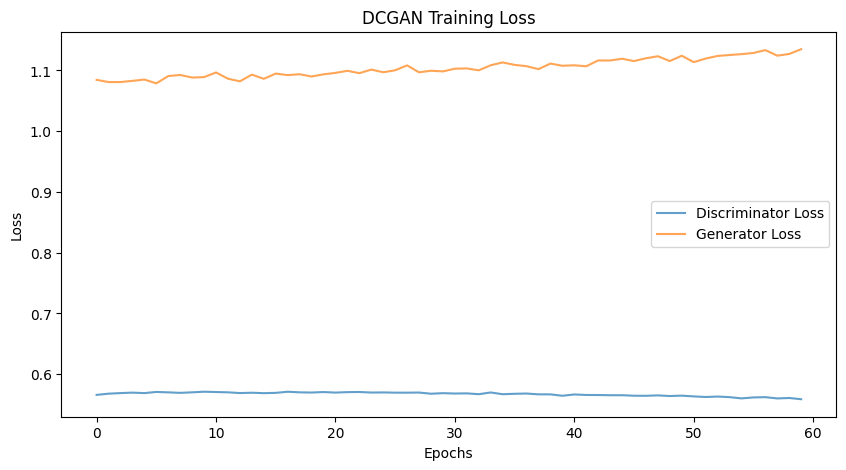

In [ ]:
import matplotlib.pyplot as plt

d_loss = gan.history.history["d_loss"]
g_loss = gan.history.history["g_loss"]

plt.figure(figsize=(10, 5))
plt.plot(d_loss, label="Discriminator Loss", alpha=0.7)
plt.plot(g_loss, label="Generator Loss", alpha=0.7)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DCGAN Training Loss")
plt.legend()
plt.show()

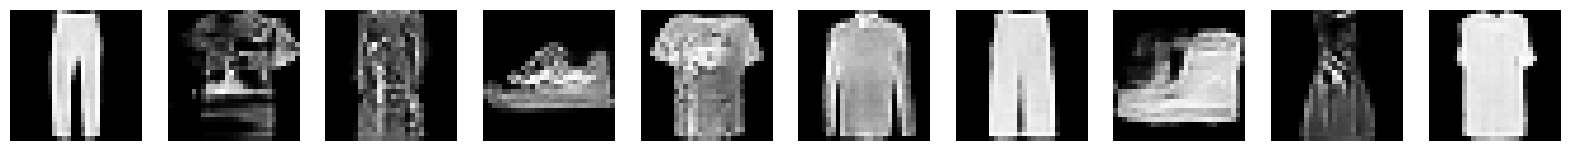

In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf


num_samples = 10
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

generated_images = gan.generator(random_latent_vectors)

generated_images = (generated_images + 1) / 2.0

# Plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i, :, :, 0], cmap="gray")
    ax.axis("off")

plt.show()
